In [38]:
import os
import pandas
import nibabel as ni
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve, auc


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
%matplotlib inline

The objective of this notebook is to apply the model derived in NB2 to an independent dataset: the BrainSpan dataset. This dataset features samples extracted from the brain of four prenatal humans, including several samples extracted from the hippocampus. The feature set is identical to that of the Allen Human Brain Atlas, making it very straightforward to generalize the model to this dataset.

The files can be downloaded here: http://www.brainspan.org/static/download.html. This data is from the Prenatal LMD Microarray Dataset

In [7]:
# Your git directory here:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/Hipp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
# Enter the path for the directory where you stored your file downloads
aba_dir = '/data1/users/jvogel/Brainspan/'

probes = pandas.read_csv(os.path.join(aba_dir,'lmd_matrix_12566/rows_metadata.csv'))

In [43]:
# If you want to save figure to disk, input the directory you want to save figures to here:

fig_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NCRevisions/'

# Regress out donor effects

In [9]:
bigsheet = []
xpsheets = sorted(glob(os.path.join(aba_dir,
                                    'lmd_matrix_*/expression_matrix.csv'
                                   ))) # collect gene expression data
dids = [x.split('/')[-2].split('matrix_')[-1] for x in xpsheets] # donor IDs

# Turn each csv into a dataframe, add donor ID, and concatenate into one big DataFrame
for sheet in xpsheets:
    did = sheet.split('/')[-2].split('matrix_')[-1] # get donor id
    gxp = pandas.read_csv(sheet,header=None)
    gxp.drop(gxp.columns[0],axis=1,inplace=True)
    
    # create dummy variables for donor
    for tid in dids:
        if tid == did:
            gxp.loc['is_%s'%tid] = 1
        else:
            gxp.loc['is_%s'%tid] = 0
    bigsheet.append(gxp)
    print('finished',did)
    
bigdf = pandas.concat(bigsheet,axis=1).transpose()

finished 12566
finished 12690
finished 12840
finished 14751


In [10]:
# PREP FOR REGRESSION
bigdf.columns = ['col_%s'%x for x in bigdf.columns[:-4]] + bigdf.columns[-4:].tolist()
resid_df = pandas.DataFrame(np.empty_like(bigdf.values),
                            index = bigdf.index, columns=bigdf.columns)
resid_df.iloc[:,-4:] = bigdf.iloc[:,-4:].values

In [11]:
# RUN STATS (took about 5-10 minute on the work computer)
for i,col in enumerate(bigdf.columns[:-4]):
    resid_df.loc[:,col] = smf.ols('%s ~ is_12566 + is_12690 + is_12840'%(col), 
                                  data=bigdf).fit().resid
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000


In [ ]:
# SAVE BACK INTO SPREADSHEETS
dfz = {}
for col in resid_df.columns[-4:]:
    did = col.split('_')[-1]
    ddir = os.path.join(aba_dir,'lmd_matrix_%s'%did)
    refsht = os.path.join(ddir,'expression_matrix.csv')
    print('loading reference csv')
    gxp = pandas.read_csv(refsht,header=None)
    gxp.drop(gxp.columns[0],axis=1,inplace=True)
    ndf = resid_df[resid_df[col]==1][resid_df.columns[:-4]].transpose()                            
    ndf.index = gxp.index                        
    ndf.columns = gxp.columns  
    print('saving new csv')
    ndf.to_csv(os.path.join(ddir,'MExp_genes_ctr_for_donor'))
    dfz.update({did: ndf})
    print('finished',did)

# Gather metadata

In [12]:
sasheets = sorted(glob(os.path.join(aba_dir,'lmd_matrix_*/columns_metadata.csv')))
sasheets

['/data1/users/jvogel/Brainspan/lmd_matrix_12566/columns_metadata.csv',
 '/data1/users/jvogel/Brainspan/lmd_matrix_12690/columns_metadata.csv',
 '/data1/users/jvogel/Brainspan/lmd_matrix_12840/columns_metadata.csv',
 '/data1/users/jvogel/Brainspan/lmd_matrix_14751/columns_metadata.csv']

In [13]:
ref = []
for sheet in sasheets:
    did = sheet.split('/')[-2].split('_')[-1]
    sa = pandas.read_csv(sheet)
    sa.loc[:,'donor'] = [did for x in range(len(sa))]
    sa.loc[:,'sample'] = [x for x in range(1,len(sa)+1)]
    ref.append(sa)
SA = pandas.concat(ref).sort_values(['donor','sample'])
SA.index = range(len(SA))

In [ ]:
data_dir = aba_dir
SA.to_csv(os.path.join(data_dir,'MAIN_gcx_wholebrain_info.csv'))

In [14]:
data_dir = aba_dir
SA = pandas.read_csv(os.path.join(data_dir,
                                  'MAIN_gcx_wholebrain_info.csv'),
                    index_col=0)

In [15]:
shtz = sorted(glob(os.path.join(aba_dir,'lmd_matrix_*/MExp_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(SA.loc[x,'donor'],bigdf.columns[x]) for x in range(SA.shape[0])]
bigdf.columns = ncols

# Identify hippocampus samples

In [16]:
hippo_labels = ['CP in caudal hippocampus',
              'CP in caudal subicular cortex',
             'CP in rostral hippocampus',
              'SP in caudal hippocampal proper',
             'SP in caudal subicular cortex',
             'VZ in caudal hippocampal proper',
             'VZ in caudal subicular cortex',
             'caudal presubiculum (postsubiculum)',
             'molecular layer of caudal subiculum',
              'polymorphic layer of caudal subiculum',
             'polymorphic layer of rostral subiculum',
             'pyramidal cells of caudal CA4',
             'pyramidal cells of rostral CA4',
             'pyramidal layer of caudal subiculum',
             'pyramidal layer of rostral subiculum',
              'rostral presubiculum',
             'stratum lacunosum-moleculare of caudal CA1',
             'stratum lacunosum-moleculare of rostral CA1',
             'stratum oriens of caudal CA1',
             'stratum oriens of rostral CA1',
             'stratum pyramidale of caudal CA1',
             'stratum pyramidale of caudal CA2',
             'stratum pyramidale of caudal CA3',
             'stratum pyramidale of rostral CA1',
             'stratum pyramidale of rostral CA2',
             'stratum pyramidale of rostral CA3',
             'stratum radiatum of caudal CA1',
             'stratum radiatum of rostral CA1',
              'subgranular zone of caudal dentate gyrus',
             'subgranular zone of rostral dentate gyrus',
             'superficial layers of caudal presubiculum',
             'caudal presubiculum (postsubiculum)',
             'granular layer of caudal dentate gyrus',
             'caudal prosubiculum']

anterior = [x for x in hippo_labels if 'rostral' in x]

posterior = [x for x in hippo_labels if 'caudal' in x]

SA.loc[:,'Hipp_Division'] = ['Anterior' if x in anterior else\
                             'Posterior' if x in posterior else\
                              np.nan for x in SA.structure_name]

# Get betas from our LASSO-PCR model


By now it kinda goes without saying but you'll need to run NB1 to generate the spreadsheets below

In [18]:
wdir = os.path.join(git_dir, 'Data')

df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)

In [19]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.6758859774822009
running final model
final model fit r2 =  0.8768105093258057
running sanity_check


In [25]:
SA.loc[:,'Hipp_betas'] = np.dot(bigdf.T, pcalr_out_NEW['betas'])

# Run it!

Ttest_indResult(statistic=4.9924825270484545, pvalue=7.3401824826989515e-06)

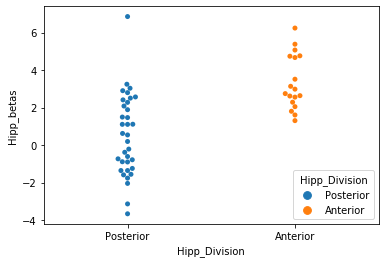

In [26]:
#sns.boxplot(x='Hipp_Division',y='Hipp_betas',data=SA)
sns.swarmplot(x='Hipp_Division',y='Hipp_betas',
              data=SA,hue='Hipp_Division')
stats.ttest_ind(SA[SA.Hipp_Division=='Anterior']['Hipp_betas'],
               SA[SA.Hipp_Division=='Posterior']['Hipp_betas'])

# Get betas for other sets

You will need to run through NB3 for these to make sense, and to have this spreadsheet

In [31]:
mod_genes = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_model_genes_of_importance.csv',
                       index_col=1)
mod_genes.head()

,Unnamed: 0,ant-post,step,gene_symbol
probe_ind,,,,
12941,0,posterior,1,GAL
47792,1,posterior,1,A_24_P102119
8962,2,posterior,1,ONECUT2
26238,3,posterior,1,PDLIM5
343,4,posterior,1,COL5A2


In [32]:
mod_genes.loc[:,'probe_ind'] = mod_genes.index

In [33]:

# Get a Probe x Sample matrix for each "gene set"
top_100 = xp.loc[mod_genes[mod_genes.step==1].index]
top_100_600 = xp.loc[mod_genes[mod_genes.step==2].index]
top_600 = xp.loc[mod_genes[mod_genes.step<3].index]
top_600_2700 = xp.loc[mod_genes[mod_genes.step==3].index]
top_2700 = xp.loc[mod_genes[mod_genes.step<4].index]
top_2700_5k = xp.loc[mod_genes[mod_genes.step==4].index]
t5k_ind = [x for x in xp.index if x not in mod_genes.probe_ind.values]
top_5k_end = xp.loc[t5k_ind]
all_subs = xp.loc[mod_genes.loc[mod_genes.index].index]


gene_sets = [top_100, top_100_600, 
             top_600_2700, top_2700_5k,
            top_5k_end, all_subs]

In [35]:

all_betas = {}

gsets = dict(zip(['top_100', 'top_100_600', 
             'top_600_2700', 'top_2700_5k',
            'top_5k_end']
                 ,gene_sets[:-1]))
gsets.update({'top_600': top_600})
gsets.update({'top_2700': top_2700})

for gset, xpdf in gsets.items():
    print('working on',gset)
    if gset != 'top_100':
        otpt = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, 
                               cv_strategy='score', illustrative=False, 
                                sanity_check_style ='model')
        all_betas.update({gset:otpt['betas']})
    else:
        otpt = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, pca=None,
                            clf = linear_model.LassoCV(cv=10, max_iter=5000),
                            cv_strategy='score', illustrative=False,
                            sanity_check_style='model')
        all_betas.update({gset:otpt['betas']})


working on top_100
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.8019898801123538
running final model
final model fit r2 =  0.9121037684478059
running sanity_check
working on top_100_600
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.7892906662272527
running final model
final model fit r2 =  0.8498231362275876
running sanity_check
working on top_600_2700
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.8295617263968729
running final model
final model fit r2 =  0.8826678229276966
running sanity_check
working on top_2700_5k
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.7069095146629284
running final model
final model fit r2 =  0.8301649965373121
running sanity_check
working on top_5k_end
running PCA
transformin

In [36]:
for gset,betas in all_betas.items():
    SA.loc[:,gset] = np.dot(bigdf.loc[gsets[gset].index].T,betas)

In [37]:
SA.loc[:,'Hipp_Code'] = [1 if x == 'Anterior' else 2 if x == 'Posterior' else np.nan for x in SA.Hipp_Division]
hipps = SA[pandas.notnull(SA.Hipp_Code)]

# Run all associations, plot swarm plots and ROC curves

Hipp_betas


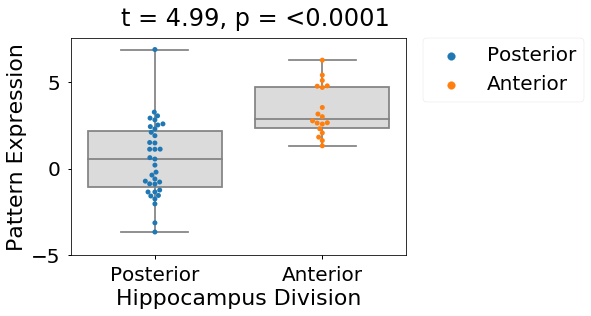

0.7735849056603774


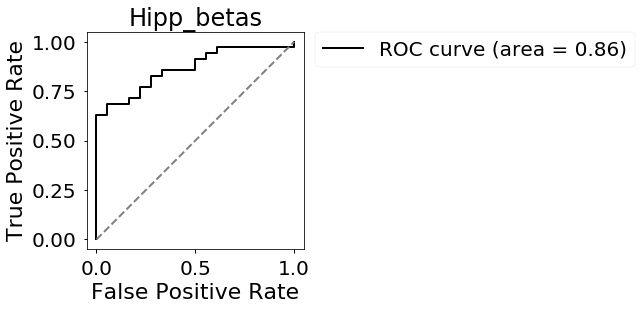

top_100


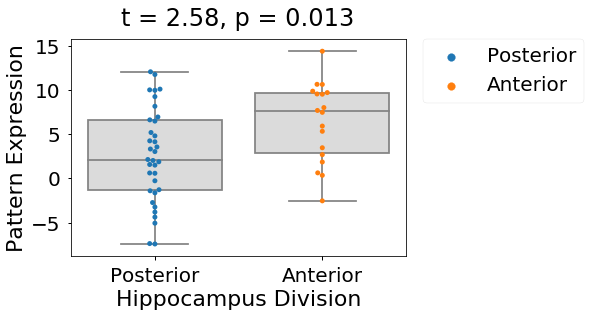

0.660377358490566


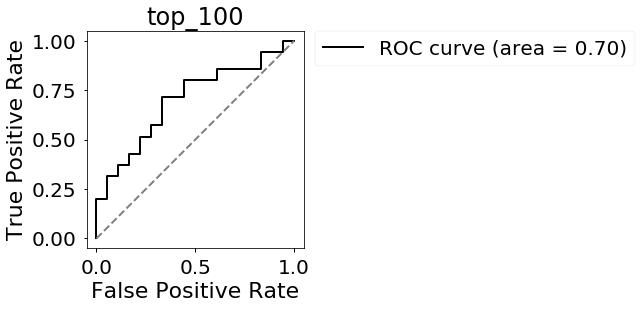

top_100_600


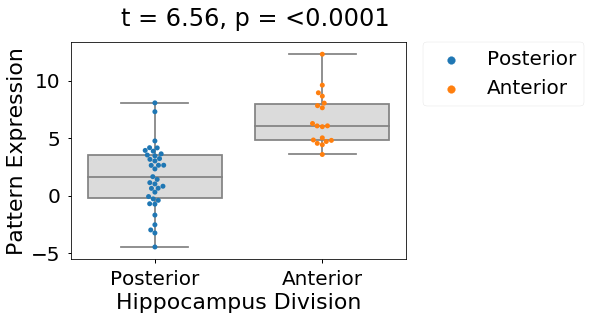

0.8301886792452831


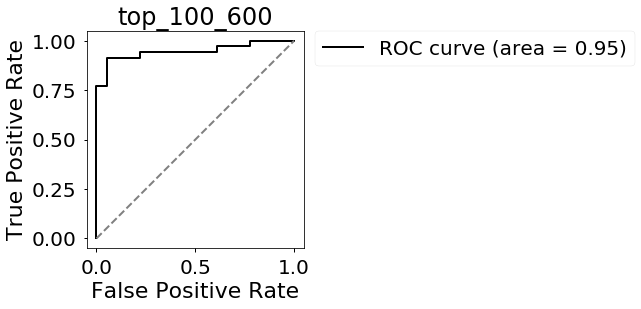

top_600_2700


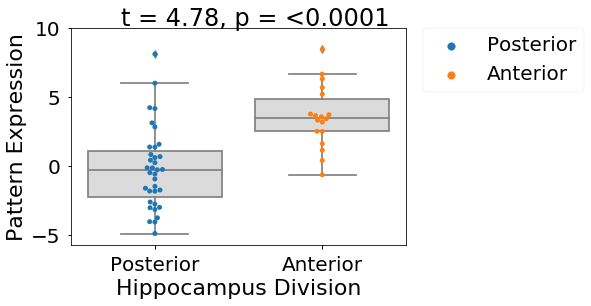

0.7924528301886793


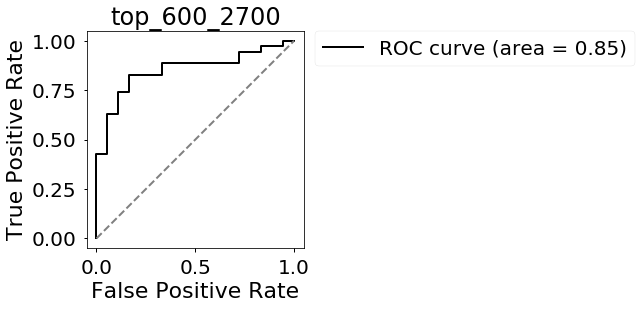

top_2700_5k


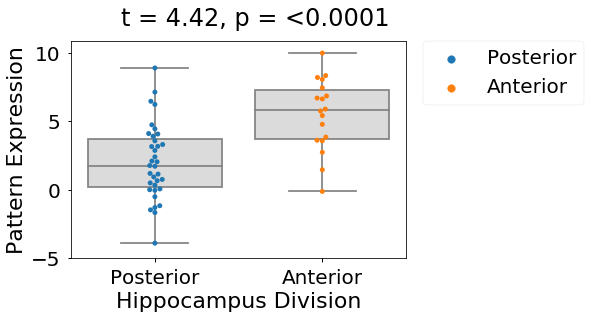

0.7924528301886793


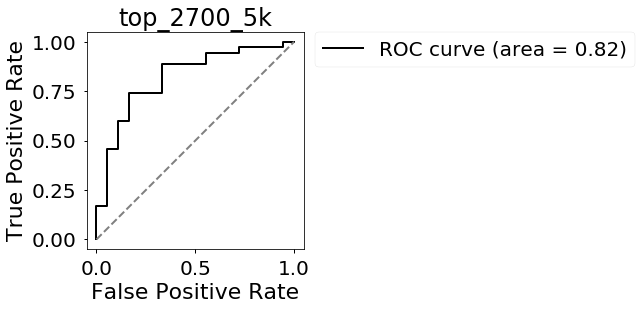

top_5k_end


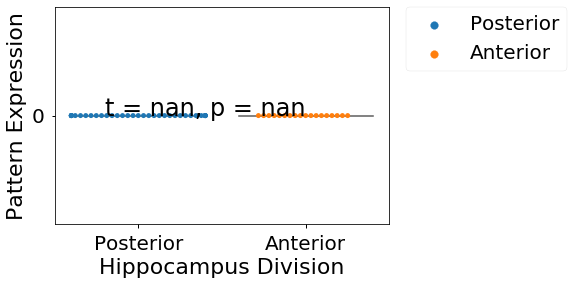

0.660377358490566


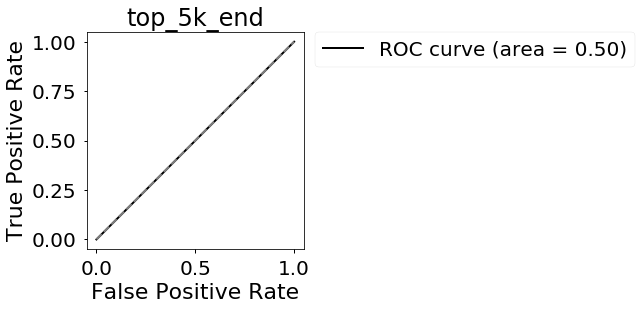

top_600


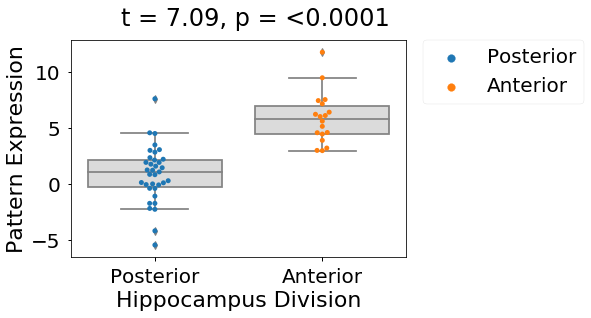

0.8679245283018868


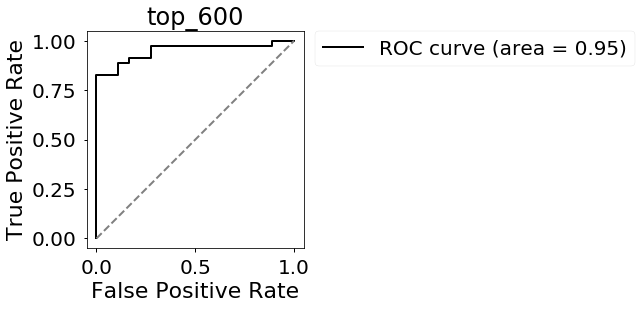

top_2700


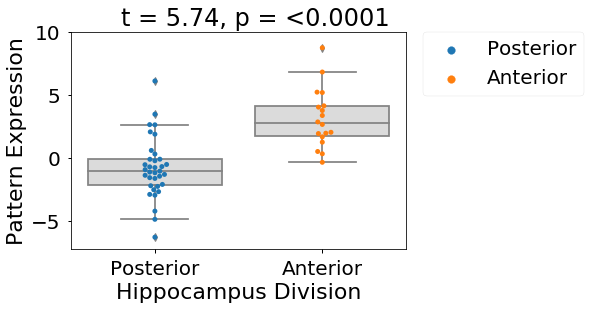

0.7735849056603774


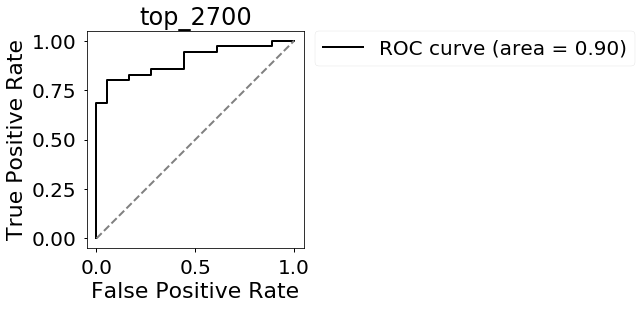

In [42]:
sns.set_context('notebook',font_scale=2)


for col in ['Hipp_betas','top_100', 'top_100_600', 'top_600_2700', 'top_2700_5k', 'top_5k_end',
       'top_600', 'top_2700',]:
    print(col)
    
    sns.boxplot(x='Hipp_Division',y=col, data=hipps, color=sns.color_palette('gray')[-1])
    sns.swarmplot(x='Hipp_Division',y=col,
                  data=hipps,hue='Hipp_Division')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Hippocampus Division')
    plt.ylabel('Pattern Expression')
    t,p = stats.ttest_ind(SA[SA.Hipp_Division=='Anterior'][col],
                    SA[SA.Hipp_Division=='Posterior'][col])
    if p < 0.0001:
        p = '<0.0001'
    else:
        p = round(p,3)
    h = max(hipps[col].values)
    plt.text(-.2,h+(h/5),'t = {}, p = {}'.format(round(t,2), p))
    
    postick = list(range(0,(int(round(hipps[col].max() / 5))*5)+1,5))
    negtick = list(range(-5,(int(round(hipps[col].min() / 5))*5)-1,-5))
    plt.yticks(negtick+postick)
    
    plt.savefig(os.path.join(fig_dir,'BOX_%s.pdf'%col), bbox_inches='tight')
    plt.show()
    
    
    mod = linear_model.LogisticRegressionCV().fit(hipps[col].values.reshape(-1,1),
                                                 hipps.Hipp_Code.values)
    pred_val = mod.predict(hipps[col].values.reshape(-1,1))
    hipps.loc[:,'Predicted_label'] = pred_val
    print(mod.score(hipps[col].values.reshape(-1,1),
                hipps.Hipp_Code.values))
                              
    n_classes = len(hipps.Hipp_Code.unique())
    y_test = hipps.Hipp_Code.values
    y_score = mod.decision_function(hipps[col].values.reshape(-1,1))

    fpr,tpr,_ = roc_curve(y_test.astype(int),y_score, pos_label=2)
    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(col)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis('square')
    plt.savefig(os.path.join(fig_dir,'AUC_%s.pdf'%col), bbox_inches='tight')
    plt.show()